In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics import tsaplots
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

### Part 1- preprocessing:

In [3]:
file_path = "International_Report_Departures.csv"
df = pd.read_csv(file_path)
display(df) #visualisation without aggregation

,data_dte,Year,Month,usg_apt_id,usg_apt,usg_wac,fg_apt_id,fg_apt,fg_wac,airlineid,carrier,carriergroup,type,Scheduled,Charter,Total
0,05/01/2006,2006,5,12016,GUM,5,13162,MAJ,844,20177,PFQ,1,Departures,0,10,10
1,05/01/2003,2003,5,10299,ANC,1,13856,OKO,736,20007,5Y,1,Departures,0,15,15
2,03/01/2007,2007,3,10721,BOS,13,12651,KEF,439,20402,GL,1,Departures,0,1,1
3,12/01/2004,2004,12,11259,DAL,74,16271,YYZ,936,20201,AMQ,1,Departures,0,1,1
4,05/01/2009,2009,5,13303,MIA,33,11075,CMW,219,21323,5L,0,Departures,0,20,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
930803,07/01/2000,2000,7,13303,MIA,33,13605,NAS,204,20398,MQ,1,Departures,1422,0,1422
930804,04/01/2019,2019,4,13303,MIA,33,14286,PTY,162,19770,CM,0,Departures,1439,0,1439
930805,08/01/2000,2000,8,13303,MIA,33,13605,NAS,204,20398,MQ,1,Departures,1441,0,1441
930806,09/01/2004,2004,9,12266,IAH,74,15632,VSA,148,19534,AM,0,Departures,1461,0,1461


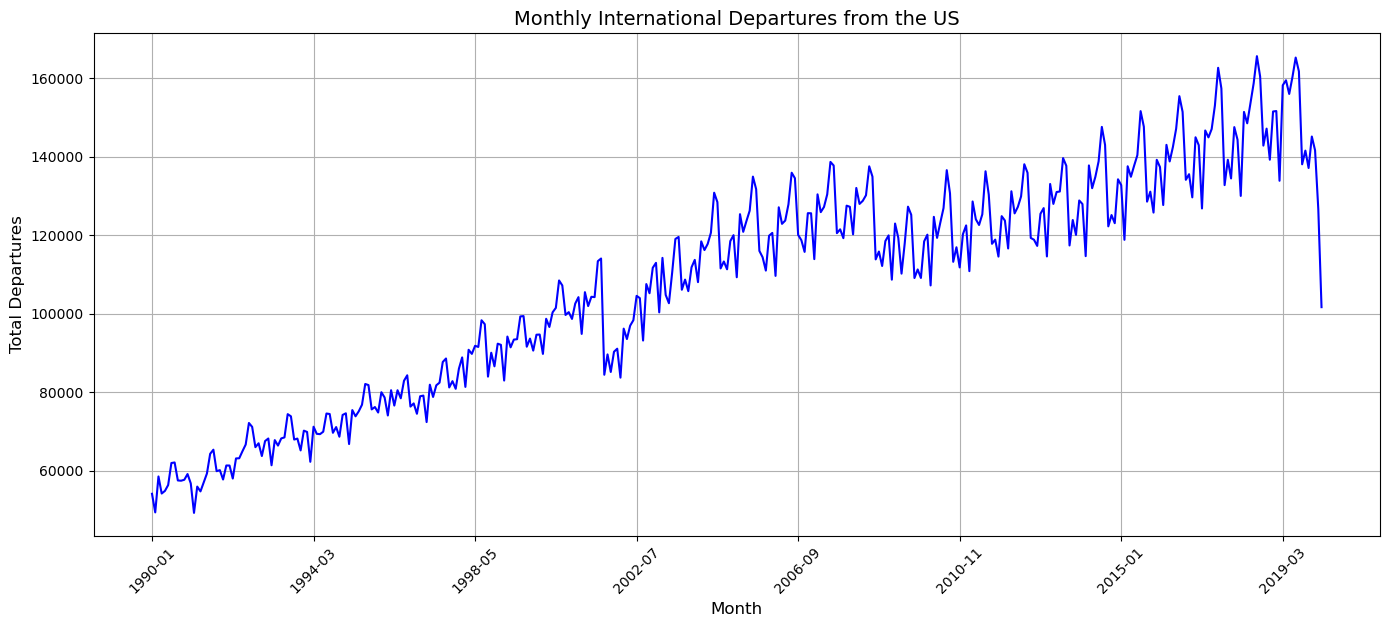

In [4]:
# Convert date column to datetime
df['data_dte'] = pd.to_datetime(df['data_dte'])

# Create a year-month column
df['year_month'] = df['data_dte'].dt.to_period('M')

# Aggregate by month: sum total departures
monthly_departures = df.groupby('year_month')['Total'].sum()

# Convert the index to string for readable axis labels
monthly_departures.index = monthly_departures.index.astype(str)

# Plotting the graph
plt.figure(figsize=(14, 6))
monthly_departures.plot(color='blue')
plt.title("Monthly International Departures from the US", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Total Departures", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [5]:
print(monthly_departures.isna().sum())        # count NaNs
print(monthly_departures.index.is_unique)     # does the dates are unique?
monthly_departures

0
True


year_month
1990-01     54129
1990-02     49391
1990-03     58542
1990-04     54195
1990-05     54863
            ...  
2019-11    137130
2019-12    145140
2020-01    141636
2020-02    126629
2020-03    101676
Name: Total, Length: 363, dtype: int64

To improve model stability and interpretability, we scaled down the number of monthly departures by a constant factor. Working with extremely large values can introduce numerical instability or affect model sensitivity. In addition, we excluded all data points after December 2019, since the COVID-19 pandemic significantly disrupted air travel patterns. Including this period would introduce an abrupt shift in the trend with no recovery data afterward, making it difficult for the model to learn meaningful patterns and forecast accurately.



In [7]:
monthly_departures = monthly_departures[monthly_departures.index <= '2019-12']
monthly_departures = monthly_departures / 1000
monthly_departures

year_month
1990-01     54.129
1990-02     49.391
1990-03     58.542
1990-04     54.195
1990-05     54.863
            ...   
2019-08    161.743
2019-09    138.071
2019-10    141.560
2019-11    137.130
2019-12    145.140
Name: Total, Length: 360, dtype: float64

Text(0, 0.5, 'Total Departures')

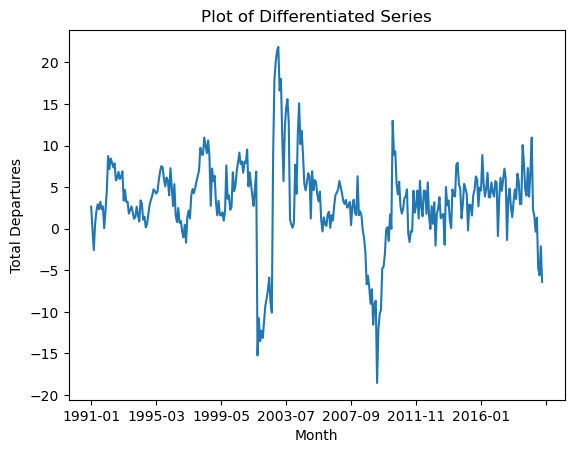

In [8]:
#Substract seasonality by using differncing
data_without_seasonality = monthly_departures.diff(periods=12)
data_without_seasonality = data_without_seasonality.dropna()
#Plot the transformed data
data_without_seasonality.plot()
plt.title("Plot of Differentiated Series")
plt.xlabel("Month")
plt.ylabel("Total Departures")

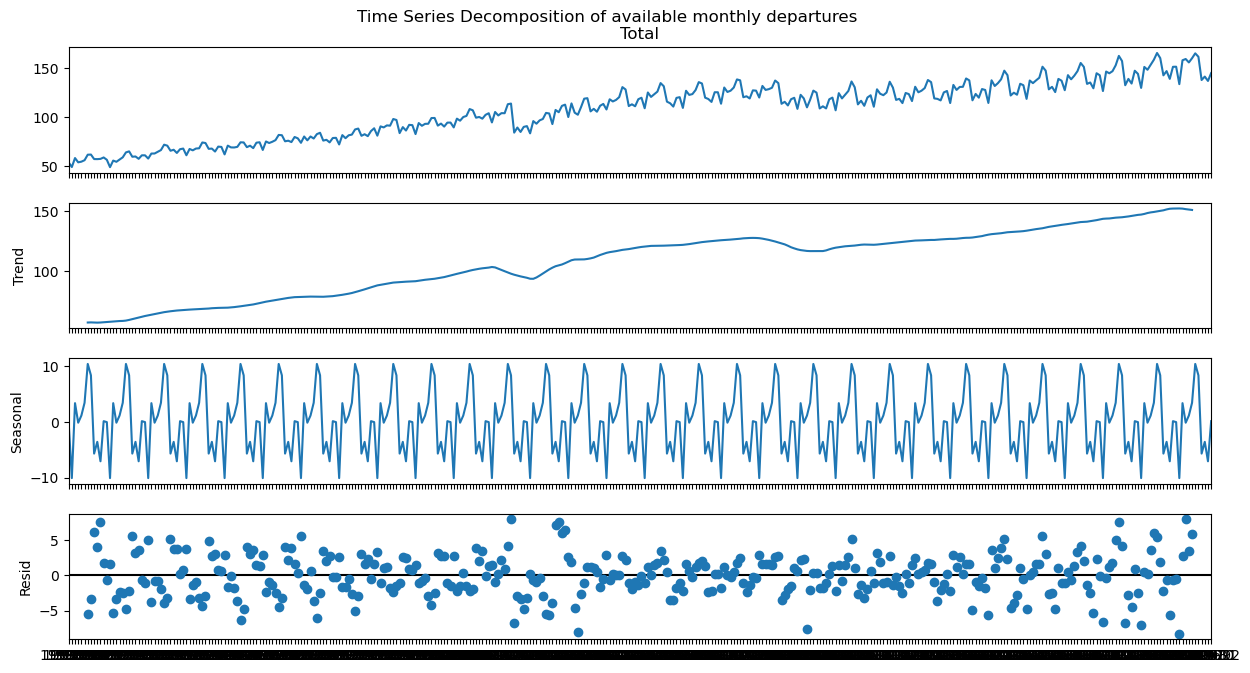

In [9]:
# Decompose the time series into trend, seasonal, and residual components
decomposition = seasonal_decompose(monthly_departures, model='additive', period=12)

# Plot the decomposed components
fig = decomposition.plot()
fig.set_size_inches(14, 7)
plt.suptitle('Time Series Decomposition of available monthly departures')
plt.show()

### Part 2

### Sarima models:

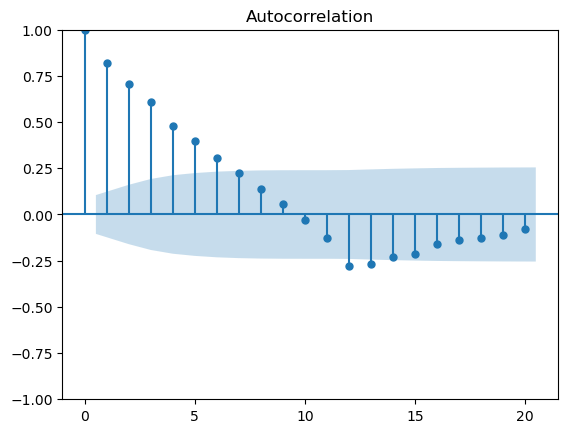

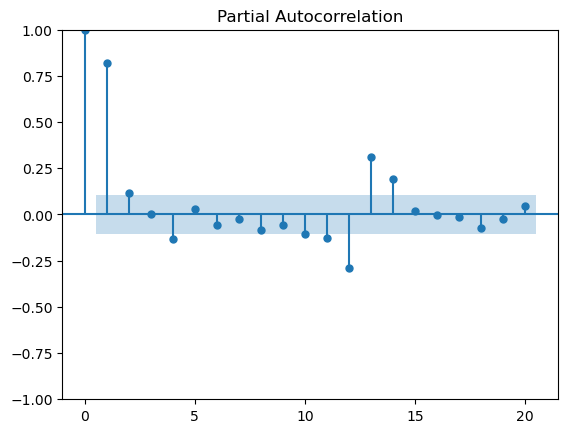

In [12]:
#Plotting the autocorrelation for the new series
tsaplots.plot_acf(data_without_seasonality, lags=20)
tsaplots.plot_pacf(data_without_seasonality, lags=20)
plt.show()

The model looks like AR(1) or equivalent to SARIMA(1,0,0)(0,1,0)_12. That because the Autocorrelation gradually decreases over time in a geometric decay pattern, which is typical for an AR(1) process. Also Partial Autocorrelation shows a significant spike at lag 2 and then cuts off sharply, so AR(2) is more likely. Another option is SARIMA(1,0,0)(1,1,0)_12 because the PACF acts like the AR's PACF. Also we can see a peak at t=11 and 12, that implies that maybe there is also AR seasonality.
In conclusion we will check: SARIMA(p,0,0)(0,1,0)_12 and SARIMA(p,0,0)(1,1,0)_12 for p=1,2


In [14]:
#SARIMA(1,0,0)(0,1,0)_{s=12}
model_AR1 = SARIMAX(monthly_departures, order=(1,0,0), seasonal_order=(0,1,0,12))
model_AR1 = model_AR1.fit(disp=False)

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [15]:
#SARIMA(1,0,0)(1,1,0)_{s=12}
model_AR1s = SARIMAX(monthly_departures, order=(1,0,0), seasonal_order=(1,1,0,12))
model_AR1s = model_AR1s.fit(disp=False)

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [16]:
#SARIMA(2,0,0)(0,1,0)_{s=12}
model_AR2 = SARIMAX(monthly_departures, order=(2,0,0), seasonal_order=(0,1,0,12))
model_AR2 = model_AR2.fit(disp=False)

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [17]:
#SARIMA(2,0,0)(1,1,0)_{s=12}
model_AR2s = SARIMAX(monthly_departures, order=(2,0,0), seasonal_order=(1,1,0,12))
model_AR2s = model_AR2s.fit(disp=False)

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [18]:
#Check the models BICs
print(f'Model AR1 BIC is : {model_AR1.bic}')
print(f'Model AR1s BIC is : {model_AR1s.bic}')
print(f'Model AR2 BIC is : {model_AR2.bic}')
print(f'Model AR2s BIC is : {model_AR2s.bic}')

Model AR1 BIC is : 1776.1815708396514
Model AR1s BIC is : 1705.5624254589086
Model AR2 BIC is : 1775.7336733704471
Model AR2s BIC is : 1695.6211018842894


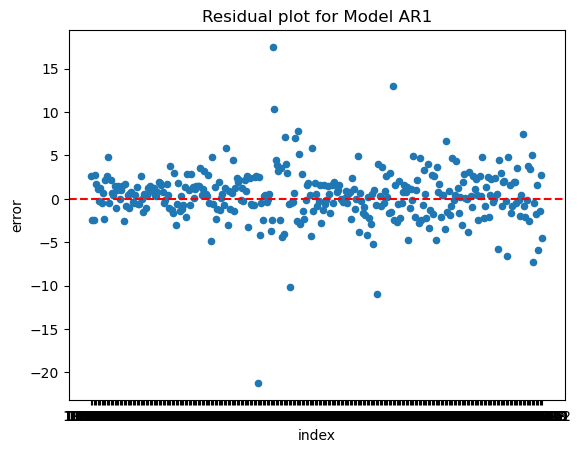

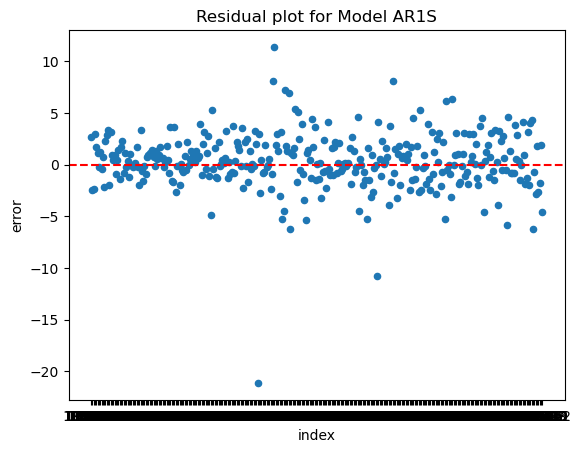

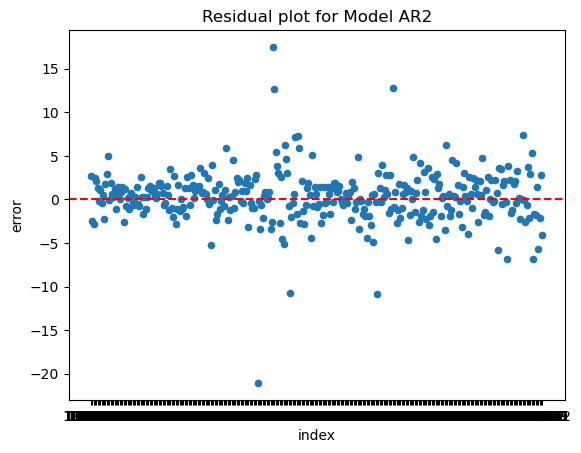

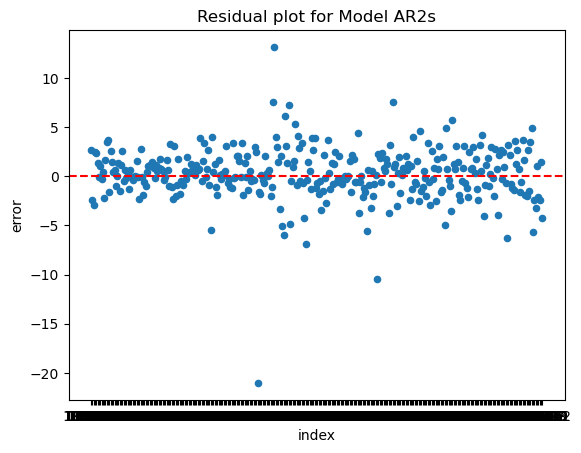

In [19]:
#Plot residual plots for every model


#Model AR1
res_plot = pd.DataFrame(model_AR1.resid.iloc[12:], columns = ['error'])
res_plot['index'] = res_plot.index
res_plot.plot.scatter(x='index', y="error")
plt.axhline(y=0, color="red", linestyle="--")
plt.title("Residual plot for Model AR1")
plt.show()

#Model AR1S
res_plot = pd.DataFrame(model_AR1s.resid.iloc[12:], columns = ['error'])
res_plot['index'] = res_plot.index
res_plot.plot.scatter(x='index', y="error")
plt.axhline(y=0, color="red", linestyle="--")
plt.title("Residual plot for Model AR1S")
plt.show()

#Model AR2
res_plot = pd.DataFrame(model_AR2.resid.iloc[12:], columns = ['error'])
res_plot['index'] = res_plot.index
res_plot.plot.scatter(x='index', y="error")
plt.axhline(y=0, color="red", linestyle="--")
plt.title("Residual plot for Model AR2")
plt.show()

#Model AR2s
res_plot = pd.DataFrame(model_AR2s.resid.iloc[12:], columns = ['error'])
res_plot['index'] = res_plot.index
res_plot.plot.scatter(x='index', y="error")
plt.axhline(y=0, color="red", linestyle="--")
plt.title("Residual plot for Model AR2s")
plt.show()

As we can see, the fourth model SARIMA(2,0,0)(1,1,0)_{s=12} , is a better fit and it has a lower BIC.All the models have pretty much the same residuals , so we will choose SARIMA(2,0,0)(1,1,0)_{s=12} as the best model.

In [21]:
print(model_AR2s.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Total   No. Observations:                  360
Model:             SARIMAX(2, 0, 0)x(1, 1, 0, 12)   Log Likelihood                -836.106
Date:                            Mon, 31 Mar 2025   AIC                           1680.212
Time:                                    22:16:51   BIC                           1695.621
Sample:                                01-01-1990   HQIC                          1686.347
                                     - 12-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7257      0.043     16.846      0.000       0.641       0.810
ar.L2          0.2128      0.043   

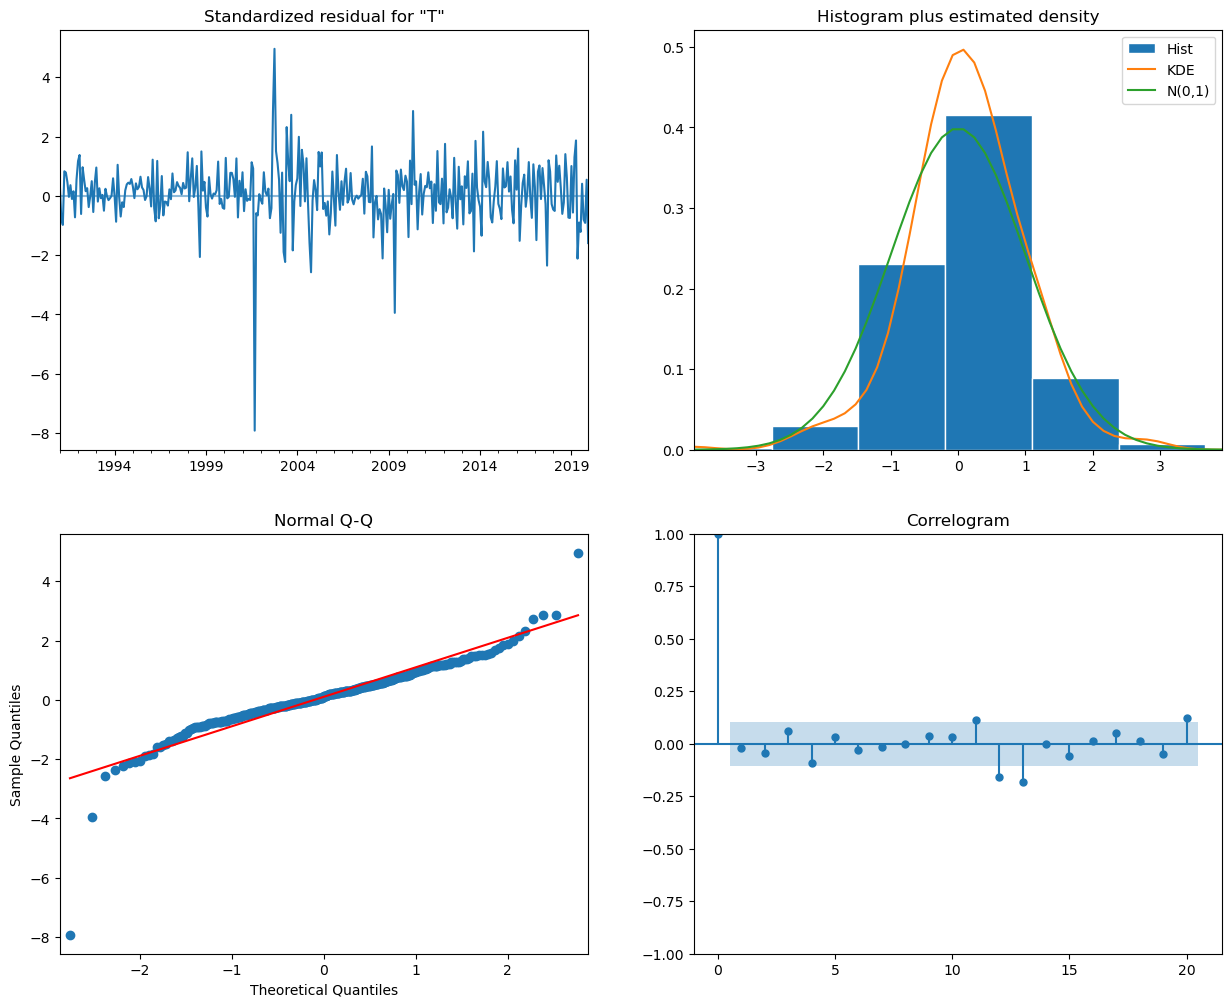

In [22]:
#Plot diagnostics
model_AR2s.plot_diagnostics(lags=20,figsize=(15, 12))
plt.show()

It's a good fit because in the QQ plot the dots  align with the line. Also, in the histogram the KDE fit very well the normal distrebution. 

In [24]:
# Forecast 60 steps ahead
forecast_steps = 60
forecast_result = model_AR2s.get_forecast(steps=forecast_steps)

# Get predicted mean and confidence intervals
forecast_mean = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

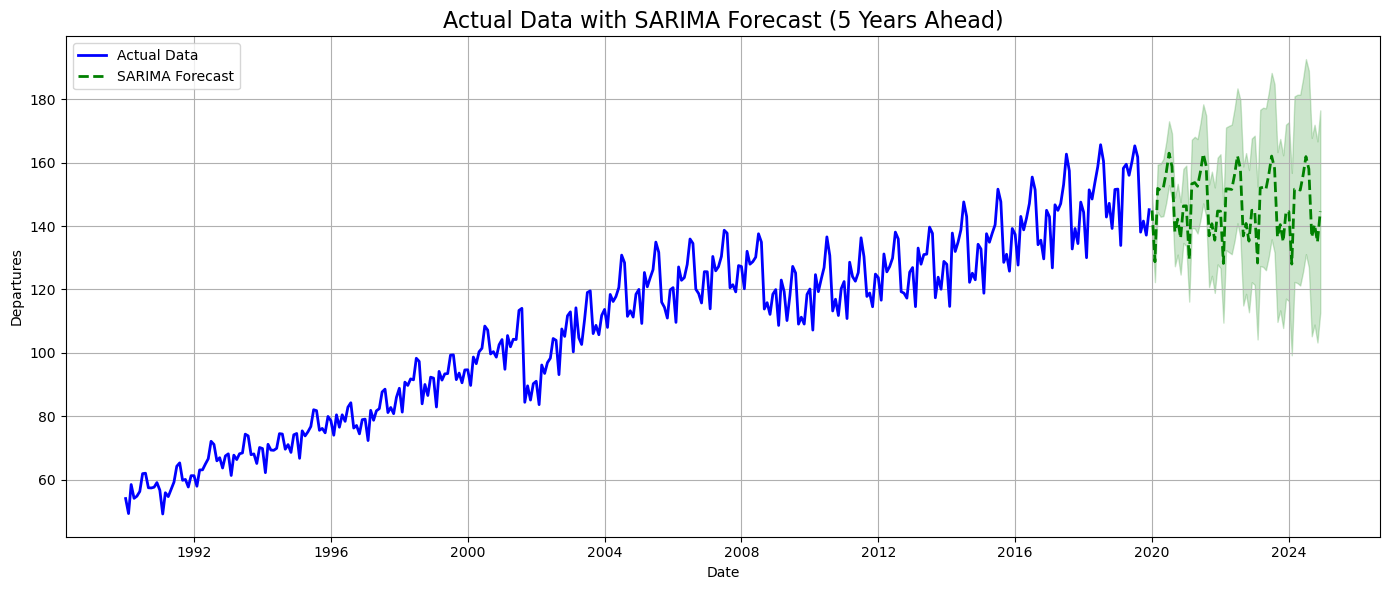

In [25]:
plt.figure(figsize=(14, 6))
monthly_departures.index = pd.to_datetime(monthly_departures.index)

# Plot actual data
plt.plot(monthly_departures, label='Actual Data', color='blue', linewidth=2)

# Plot forecast
forecast_index = pd.date_range(start=monthly_departures.index[-1] + pd.offsets.MonthBegin(1), 
                               periods=forecast_steps, freq='MS')

plt.plot(forecast_index, forecast_mean, label='SARIMA Forecast', color='green', linestyle='--', linewidth=2)

# Confidence interval
plt.fill_between(forecast_index, 
                 conf_int.iloc[:, 0], 
                 conf_int.iloc[:, 1], 
                 color='green', alpha=0.2)

# Labels
plt.title('Actual Data with SARIMA Forecast (5 Years Ahead)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Departures')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Propthet model:

In [27]:
df_prophet = monthly_departures.reset_index()
df_prophet.columns = ['ds', 'y']

df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

print(df_prophet.head())

          ds       y
0 1990-01-01  54.129
1 1990-02-01  49.391
2 1990-03-01  58.542
3 1990-04-01  54.195
4 1990-05-01  54.863


In [28]:
model_p = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=True)
model_p.fit(df_prophet)

22:16:53 - cmdstanpy - INFO - Chain [1] start processing
22:16:53 - cmdstanpy - INFO - Chain [1] done processing


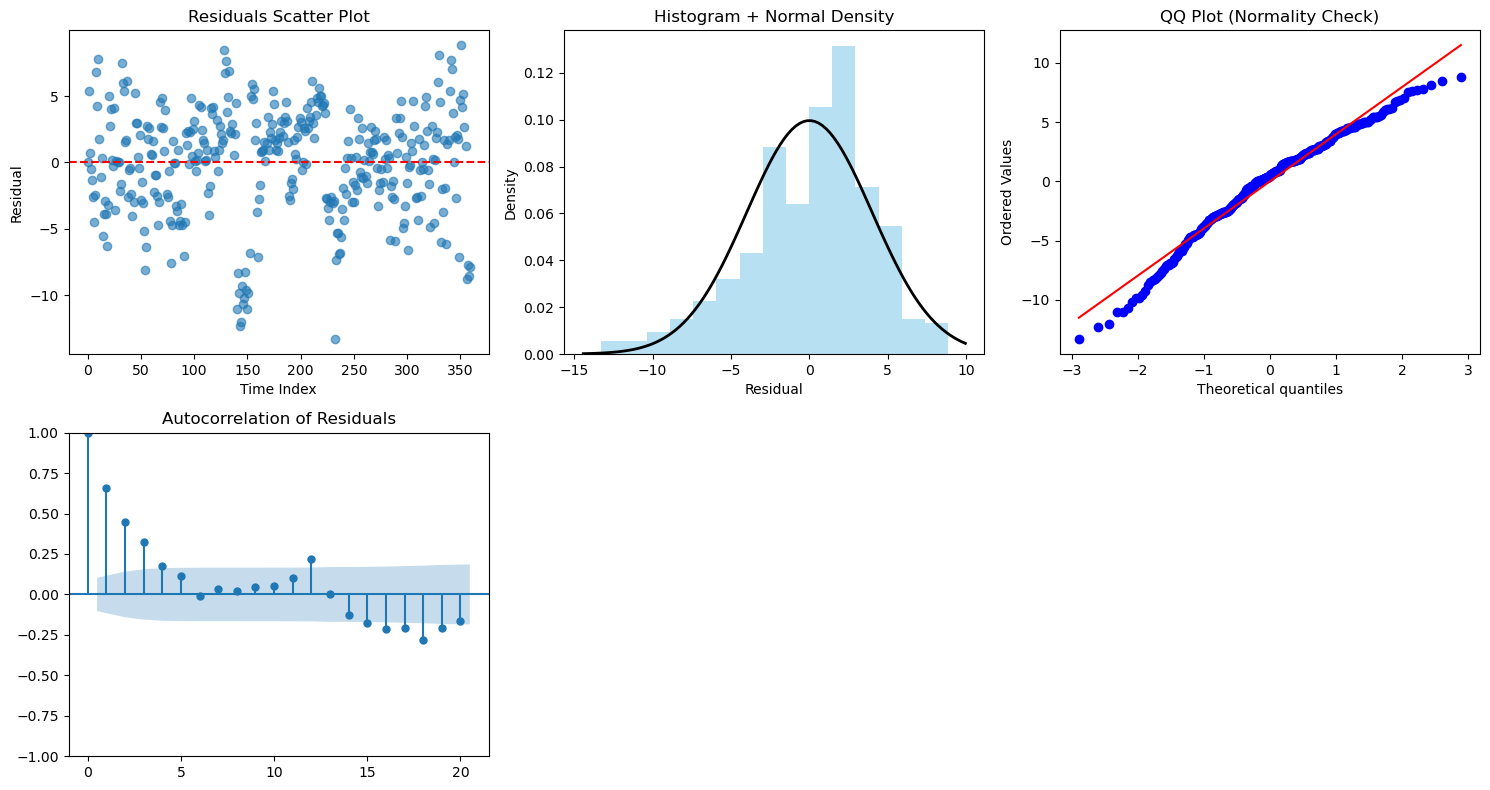

In [29]:
#Create residuals between actual and predicted values
actual = monthly_departures.values
future_df = model_p.make_future_dataframe(periods=365)
forecast_df = model_p.predict(future_df)
predicted = forecast_df['yhat'].iloc[:len(actual)].values
residuals = actual - predicted

#Plot diagnostics
plt.figure(figsize=(15, 8))

# Plot 1: Residuals scatter plot
plt.subplot(231)
plt.scatter(range(len(residuals)), residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals Scatter Plot')
plt.xlabel('Time Index')
plt.ylabel('Residual')

# Plot 2: Histogram with normal distribution overlay
plt.subplot(232)
plt.hist(residuals, bins=15, density=True, alpha=0.6, color='skyblue')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
pdf = stats.norm.pdf(x, np.mean(residuals), np.std(residuals))
plt.plot(x, pdf, 'k', linewidth=2)
plt.title('Histogram + Normal Density')
plt.xlabel('Residual')
plt.ylabel('Density')

# Plot 3: QQ Plot to check normality
plt.subplot(233)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('QQ Plot (Normality Check)')

# Plot 4: Autocorrelation of residuals
plt.subplot(234)
plot_acf(residuals, ax=plt.gca(), lags=20)
plt.title('Autocorrelation of Residuals')

plt.tight_layout()
plt.show()

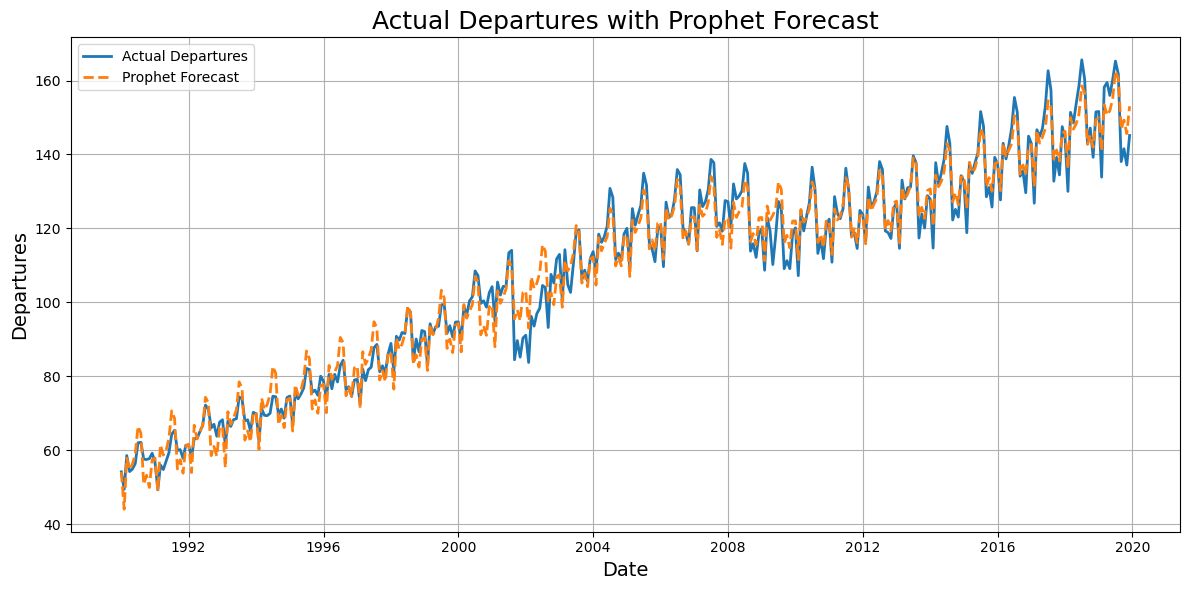

In [30]:
monthly_departures.index = pd.to_datetime(monthly_departures.index)

forecast_df['ds'] = pd.to_datetime(forecast_df['ds'])
# Trim forecast to actual data range
forecast_trimmed = forecast_df[forecast_df['ds'] <= '2019-12-01']

plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(monthly_departures.index, monthly_departures.values, label='Actual Departures', linewidth=2)

# Plot forecast
plt.plot(forecast_trimmed['ds'], forecast_trimmed['yhat'], label='Prophet Forecast', linewidth=2, linestyle='--')

plt.title("Actual Departures with Prophet Forecast", fontsize=18)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Departures", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### It seems that this model is a good fit to our data???

### Frocast with prophet:

In [33]:
# Get the last date in your actual data
last_date = monthly_departures.index.max()

# Forecast 5 years ahead (60 months)
future = model_p.make_future_dataframe(periods=60, freq='ME')
forecast = model_p.predict(future)

# Take only the future part of the forecast
forecast_future = forecast[forecast['ds'] > last_date]

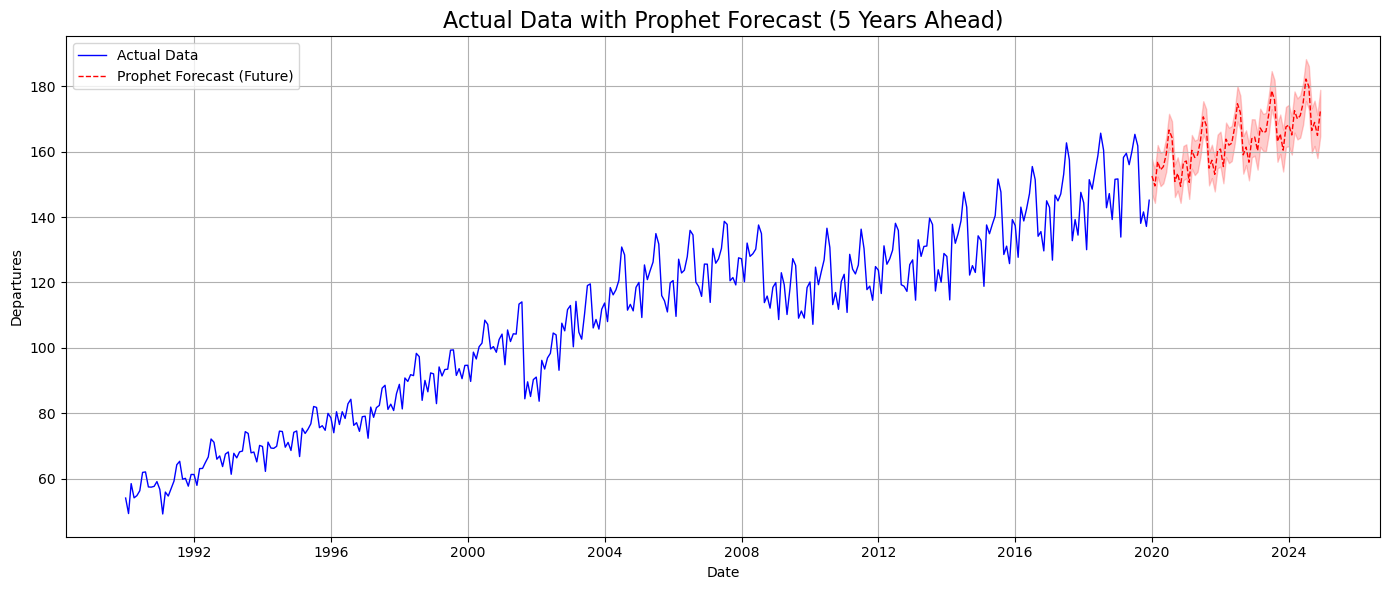

In [34]:
# Actual data
plt.figure(figsize=(14, 6))  

plt.plot(monthly_departures.index, monthly_departures.values, 
         label='Actual Data', color='blue', linewidth=1)

# Forecast line (only future)
plt.plot(forecast_future['ds'], forecast_future['yhat'], 
         label='Prophet Forecast (Future)', color='red', linewidth=1, linestyle='--')

# Confidence interval
plt.fill_between(forecast_future['ds'], 
                 forecast_future['yhat_lower'], 
                 forecast_future['yhat_upper'], 
                 color='red', alpha=0.2)

# Labels & styling
plt.title("Actual Data with Prophet Forecast (5 Years Ahead)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Departures")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Exponential Smoothing with Holt winters:

In [36]:
monthly_departures.index = pd.to_datetime(monthly_departures.index)
monthly_departures = monthly_departures.asfreq('MS')  # Monthly Start

# Fit Exponential Smoothing model with trend and seasonality
model = ExponentialSmoothing(
    monthly_departures,
    trend='add',         
    seasonal='add',
    seasonal_periods=12 )

fit = model.fit()

forecast_steps = 60
forecast_index = pd.date_range(start=monthly_departures.index[-1] + pd.offsets.MonthBegin(1),
                               periods=forecast_steps, freq='MS')

forecast = fit.forecast(forecast_steps)
forecast.index = forecast_index

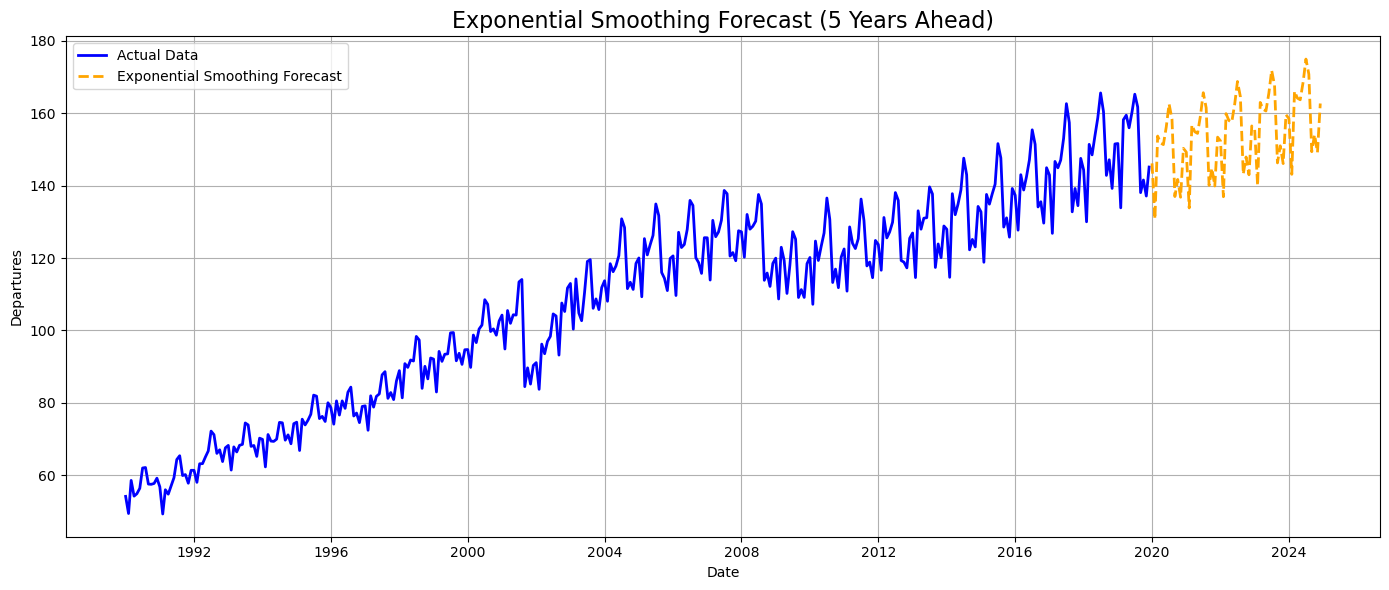

In [37]:
plt.figure(figsize=(14, 6))

# Original data
plt.plot(monthly_departures, label='Actual Data', linewidth=2, color='blue')

# Forecast
plt.plot(forecast, label='Exponential Smoothing Forecast', linewidth=2, color='orange', linestyle='--')

plt.title('Exponential Smoothing Forecast (5 Years Ahead)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Departures')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Forcast with fourier

In [39]:
monthly_departures = monthly_departures.to_frame(name='departures')

monthly_departures.index = pd.to_datetime(monthly_departures.index)
monthly_departures


,departures
year_month,
1990-01-01,54.129
1990-02-01,49.391
1990-03-01,58.542
1990-04-01,54.195
1990-05-01,54.863
...,...
2019-08-01,161.743
2019-09-01,138.071
2019-10-01,141.560


In [40]:
rng = pd.date_range(start = '1990-01-01', end = '2019-12-01', freq='MS')
monthly_departures.set_index(rng, inplace=True)#change index to dates.
monthly_departures.head()


,departures
1990-01-01,54.129
1990-02-01,49.391
1990-03-01,58.542
1990-04-01,54.195
1990-05-01,54.863


In [41]:
slope = (
    monthly_departures['departures'].iloc[-1] - 
    monthly_departures['departures'].iloc[0]
) / (len(monthly_departures) - 1)
slope

0.2535125348189415

In [42]:
trend_values = np.zeros(len(monthly_departures))
for i in range(len(monthly_departures)):
    trend_values[i] = slope * i

In [43]:
monthly_departures['value'] = monthly_departures['departures'] - trend_values


<Axes: >

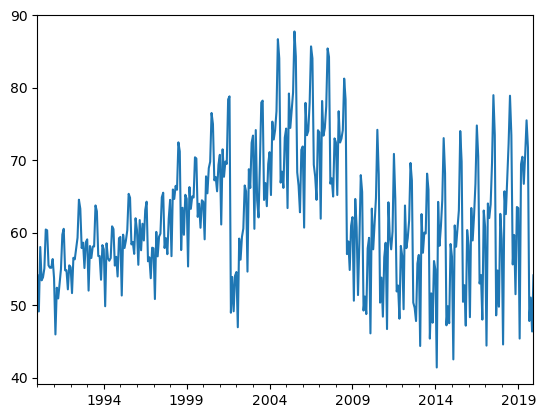

In [44]:
monthly_departures['value'].plot()

as a first step, we attempted to remove a global linear trend from the time series in order to isolate its seasonal component. However, as seen in the detrended series, this approach fails to fully capture the underlying structure of the data. The resulting series still exhibits visible shifts in trend and variability, suggesting that a single linear trend is insufficient. These structural changes, likely due to real-world events or regime shifts, indicate the presence of multiple trend segments over time. To better handle these breaks and to more accurately model the recurring seasonal behavior, we turn to a regression framework that combines Fourier terms with piecewise linear trends. This allows us to flexibly account for both seasonal dynamics and non-uniform trend changes in the data.

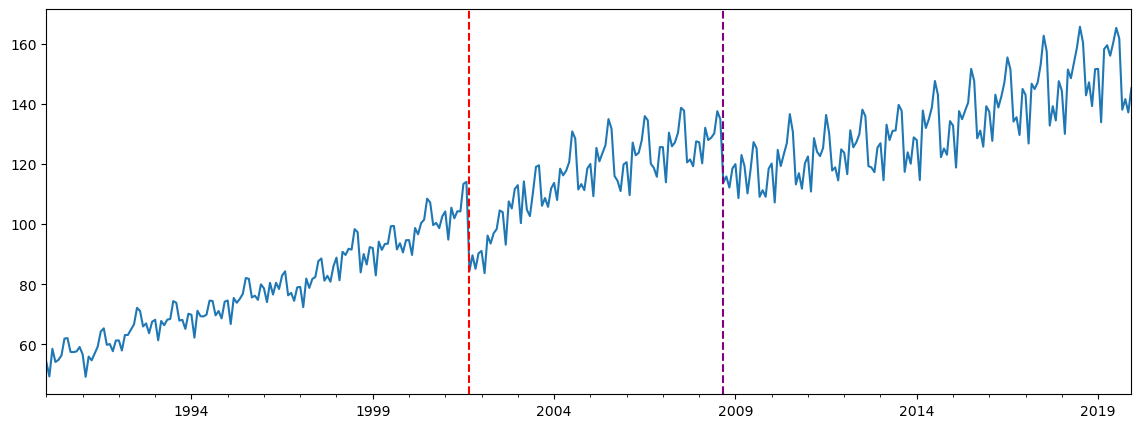

In [46]:
monthly_departures['departures'].plot(figsize=(14, 5))
plt.axvline('2001-09-01', color='red', linestyle='--') 
plt.axvline('2008-09-01', color='purple', linestyle='--')
#plt.axvline('2019-12-01', color='green', linestyle='--')
plt.show()


In [47]:
monthly_departures.index = pd.to_datetime(monthly_departures.index)

monthly_departures = monthly_departures.sort_index()

monthly_departures['t'] = np.arange(len(monthly_departures))

X_linear = np.array([np.ones(len(monthly_departures)), monthly_departures['t']]).T
X_linear[:5] 


array([[1., 0.],
       [1., 1.],
       [1., 2.],
       [1., 3.],
       [1., 4.]])

In [48]:
# Define the train-test split ratio
split_ratio = 0.8 # 80% for training, 20% for testing
# Calculate the split index
split_index = int(len(monthly_departures) * split_ratio)
# Split the data
train_df = monthly_departures.iloc[:split_index]
train_y = train_df['departures']
test_df = monthly_departures.iloc[split_index:]
test_y = test_df['departures']

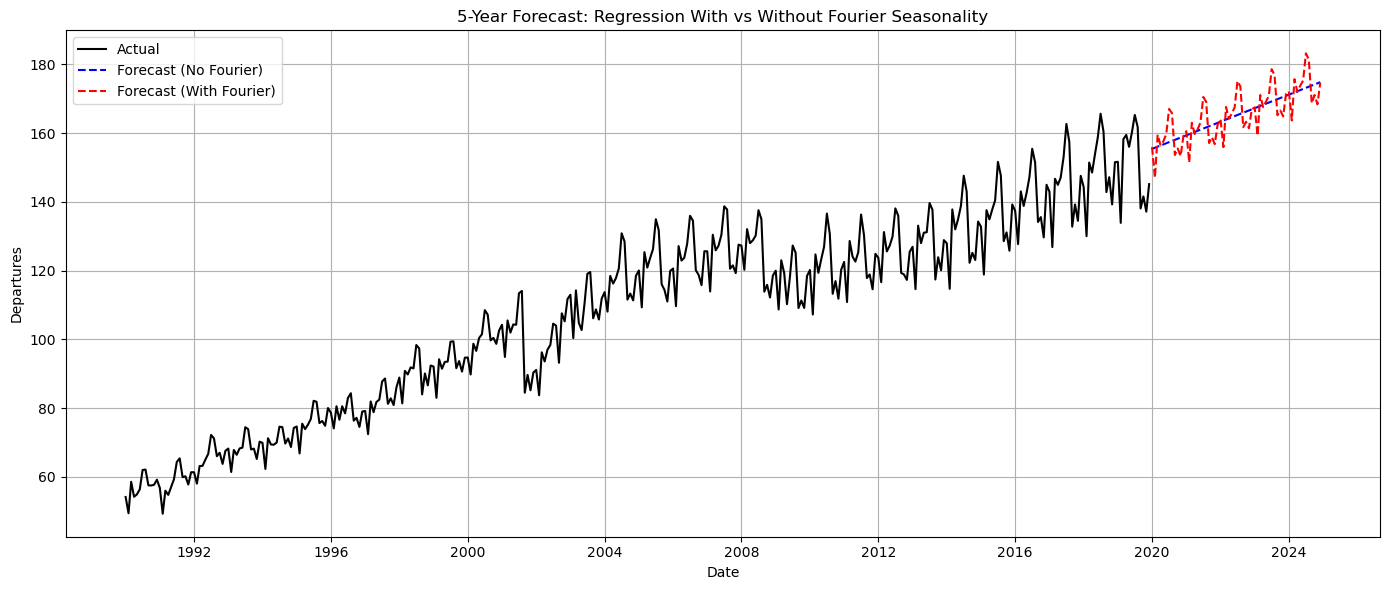

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# נניח ש-'monthly_departures' כבר כולל את העמודה 'departures' ואת 't'

# הגדרת t
t = np.arange(len(monthly_departures))
monthly_departures['t'] = t

# יצירת X_linear = bias + t
X_linear = np.column_stack([np.ones(len(t)), t])

# שוקים: 2001 ו-2008
shock_2001_slope = np.array([min(int(i >= 141) * (i - 141), 9) for i in t])
shock_2008_slope = np.array([min(int(i >= 225) * (i - 225), 15) for i in t])
X_shocks = np.column_stack([shock_2001_slope, shock_2008_slope])

# טורי פורייה: K=6
lambdas = 2 * np.pi * np.arange(1, 7) / 12
X_seasonality = np.array([
    np.concatenate([np.cos(lambdas * ti), np.sin(lambdas * ti)])
    for ti in t
])

# הגדרת X
X_basic = np.concatenate([X_linear, X_shocks], axis=1)
X_extra = np.concatenate([X_linear, X_seasonality, X_shocks], axis=1)

# y
y = monthly_departures['departures']

# חלוקה ל-train/test
split_index = int(len(monthly_departures) * 0.8)
Xb_train, Xb_test = X_basic[:split_index], X_basic[split_index:]
Xe_train, Xe_test = X_extra[:split_index], X_extra[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# אימון מודלים
model_basic = LinearRegression().fit(Xb_train, y_train)
model_fourier = LinearRegression().fit(Xe_train, y_train)

# תחזית עתידית – 5 שנים
future_steps = 60
t_last = t[-1]
t_future = np.arange(t_last + 1, t_last + future_steps + 1)

# יצירת future features
X_linear_future = np.column_stack([np.ones(len(t_future)), t_future])
shock_2001_future = np.array([min(int(i >= 141) * (i - 141), 9) for i in t_future])
shock_2008_future = np.array([min(int(i >= 225) * (i - 225), 15) for i in t_future])
X_shocks_future = np.column_stack([shock_2001_future, shock_2008_future])
X_fourier_future = np.array([
    np.concatenate([np.cos(lambdas * ti), np.sin(lambdas * ti)])
    for ti in t_future
])
X_basic_future = np.concatenate([X_linear_future, X_shocks_future], axis=1)
X_extra_future = np.concatenate([X_linear_future, X_fourier_future, X_shocks_future], axis=1)

# חיזוי
forecast_basic = model_basic.predict(X_basic_future)
forecast_fourier = model_fourier.predict(X_extra_future)

# תאריכי עתיד
start_date = monthly_departures.index[-1] + pd.offsets.MonthBegin(1)
future_dates = pd.date_range(start=start_date, periods=future_steps, freq='MS')

# ציור
plt.figure(figsize=(14, 6))
plt.plot(monthly_departures.index, monthly_departures['departures'], label="Actual", color='black')
plt.plot(future_dates, forecast_basic, label="Forecast (No Fourier)", linestyle='--', color='blue')
plt.plot(future_dates, forecast_fourier, label="Forecast (With Fourier)", linestyle='--', color='red')
plt.title("5-Year Forecast: Regression With vs Without Fourier Seasonality")
plt.xlabel("Date")
plt.ylabel("Departures")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### linear trend + seasonality


In [51]:
def plot_preds(y_preds, y_true, title):
 """
 plot the results of each model fitting
 Parameters:
 y_preds(dict): keys-model_names, values-y_preds of the models
 y_true (array-like): y_true values
 title (string): title for the plot
 """
 plt.figure(figsize=(7, 5))
 for model_name, y_pred in y_preds.items():
     plt.plot(y_true.index, y_pred, label=model_name, alpha=0.3)
 plt.plot(y_true, label='True', color='orange')
 plt.xlabel('Month in the time series')
 plt.ylabel('Retail')
 plt.title(title)
 plt.legend()
 plt.show()


Linear (no Fourier) MSE: 101.74
Linear (with Fourier) MSE: 38.05


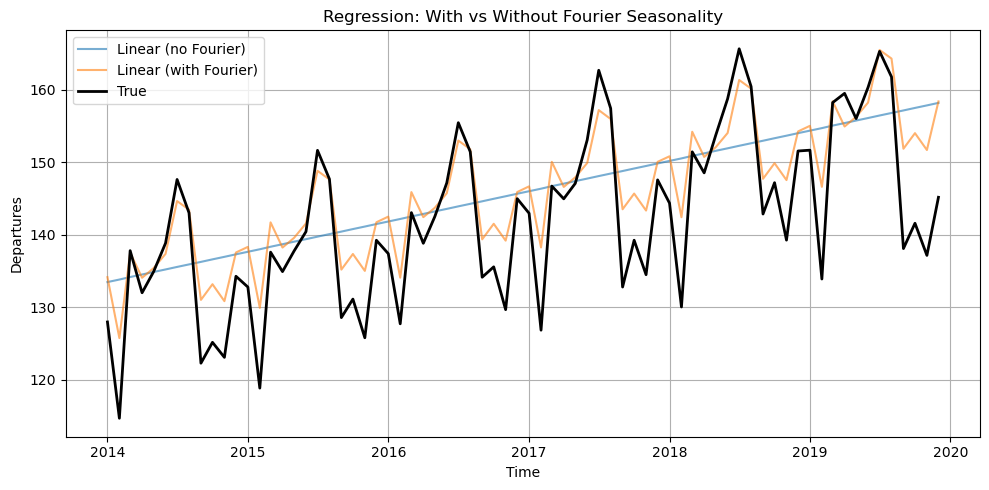

                              MSE
Linear (with Fourier)   38.052373
Linear (no Fourier)    101.741288


In [52]:
# הכנת המשתנים
t = monthly_departures['t'].values
split_index = int(len(t) * 0.8)

# בסיסי – טרנד ושוקים בלבד
X_linear = np.column_stack([np.ones(len(t)), t])

shock_2001_slope = np.array([
    min(int(i >= 141) * (i - 141), 2)
    for i in t
])
shock_2008_slope = np.array([
    min(int(i >= 225) * (i - 225), 2)
    for i in t
])
X_shocks = np.column_stack([shock_2001_slope, shock_2008_slope])

X_basic = np.concatenate([X_linear, X_shocks], axis=1)

# עונתיות פורייה
lambdas = 2 * np.pi * np.arange(1, 7) / 12
X_fourier = np.array([
    np.concatenate([np.cos(lambdas * ti), np.sin(lambdas * ti)])
    for ti in t
])

X_extra = np.concatenate([X_linear, X_fourier, X_shocks], axis=1)

# חלוקה ל-train/test
y = monthly_departures['departures']
Xb_train, Xb_test = X_basic[:split_index], X_basic[split_index:]
Xe_train, Xe_test = X_extra[:split_index], X_extra[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# אימון מודלים
models = {
    "Linear (no Fourier)": LinearRegression(),
    "Linear (with Fourier)": LinearRegression()
}

y_preds = {}
MSE = {}

for name, model in models.items():
    if "no Fourier" in name:
        model.fit(Xb_train, y_train)
        preds = model.predict(Xb_test)
    else:
        model.fit(Xe_train, y_train)
        preds = model.predict(Xe_test)

    y_preds[name] = preds
    MSE[name] = mean_squared_error(y_test, preds)
    print(f"{name} MSE: {MSE[name]:.2f}")

# ציור
def plot_preds(y_preds, y_true, title):
    plt.figure(figsize=(10, 5))
    for model_name, y_pred in y_preds.items():
        plt.plot(y_true.index, y_pred, label=model_name, alpha=0.6)
    plt.plot(y_true, label='True', color='black', linewidth=2)
    plt.xlabel('Time')
    plt.ylabel('Departures')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# הפוך את y_test לסדרה עם אינדקס של תאריכים
y_test = pd.Series(y_test.values, index=monthly_departures.index[split_index:])
plot_preds(y_preds, y_test, "Regression: With vs Without Fourier Seasonality")

# טבלת MSE
results_df = pd.DataFrame.from_dict(MSE, orient='index', columns=['MSE']).sort_values(by='MSE')
print(results_df)


### Comparison between the performance of the models: train-test split

In [54]:
# Define the train-test split ratio
split_ratio = 0.8 # 80% for training, 20% for testing
# Calculate the split index
split_index = int(len(monthly_departures) * split_ratio)
# Split the data
train_df = monthly_departures.iloc[:split_index]
train_y = train_df['departures']
test_df = monthly_departures.iloc[split_index:]
test_y = test_df['departures']
print(test_y)

2014-01-01    127.946
2014-02-01    114.671
2014-03-01    137.781
2014-04-01    131.974
2014-05-01    134.887
               ...   
2019-08-01    161.743
2019-09-01    138.071
2019-10-01    141.560
2019-11-01    137.130
2019-12-01    145.140
Freq: MS, Name: departures, Length: 72, dtype: float64


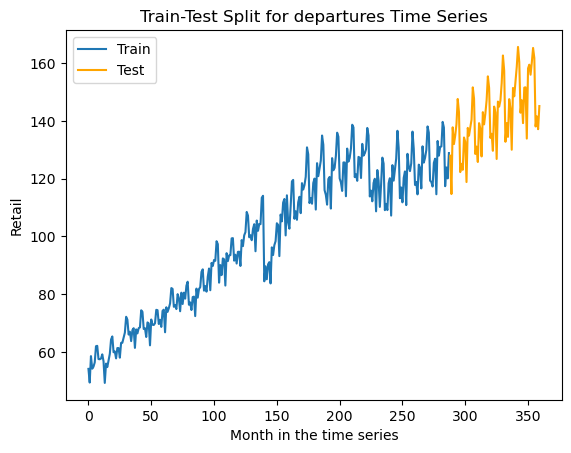

Train Data Shape: (288, 3)
Test Data Shape: (72, 3)


In [55]:
 # Plot the train-test split
plt.plot(np.arange(len(train_df)), train_df['departures'], label='Train')
plt.plot(np.arange(len(train_df), len(monthly_departures)), test_df['departures'], label='Test', color='orange')
plt.xlabel('Month in the time series')
plt.ylabel('Retail')
plt.title('Train-Test Split for departures Time Series')
plt.legend()
plt.show()
# Print shapes of splits
print("Train Data Shape:", train_df.shape)
print("Test Data Shape:", test_df.shape)

In [56]:
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
import pandas as pd

# --- פונקציות אימון וחיזוי ---

def train_predict_sarima(train_y, test_y):
    model = SARIMAX(train_y, order=(2, 0, 0), seasonal_order=(1, 1, 0, 12))
    fitted = model.fit(disp=False)
    forecast = fitted.forecast(steps=len(test_y))
    mse = mean_squared_error(test_y, forecast)
    return forecast, mse

def train_predict_expsmooth(train_y, test_y):
    model = ExponentialSmoothing(train_y, trend='add', seasonal='add', seasonal_periods=12)
    fitted = model.fit()
    forecast = fitted.forecast(steps=len(test_y))
    mse = mean_squared_error(test_y, forecast)
    return forecast, mse

def train_predict_prophet(prophet_df, test_len, test_y):
    model = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=True)
    model.fit(prophet_df)
    future = model.make_future_dataframe(periods=test_len, freq='MS')
    forecast = model.predict(future)
    y_hat = forecast['yhat'].iloc[-test_len:].values
    mse = mean_squared_error(test_y, y_hat)
    return y_hat, mse

# --- הכנה להרצה ---

models_names_list = ["Sarima", "ExponentialSmoothing", "Prophet"]
models = {}
MSE = {}
y_preds = {}

# Prophet-specific df (לפי המבנה שלך)
prophet_df = monthly_departures.reset_index().rename(columns={
    'year_month': 'ds', 'departures': 'y'
})
prophet_df = prophet_df[['index', 'y']].rename(columns={'index': 'ds'})

# חלוקה רגילה (בהנחה שכבר קיימת אצלך)
# train_df, test_df, train_y, test_y

for model_name in models_names_list:
    print(f"\n🔄 Training {model_name}...")

    if model_name == "Sarima":
        y_hat, mse = train_predict_sarima(train_y, test_y)
    
    elif model_name == "ExponentialSmoothing":
        y_hat, mse = train_predict_expsmooth(train_y, test_y)
    
    elif model_name == "Prophet":
        y_hat, mse = train_predict_prophet(prophet_df, len(test_y), test_y)

    models[model_name] = y_hat
    y_preds[model_name] = y_hat
    MSE[model_name] = mse
    print(f"✅ {model_name} done. MSE = {mse:.2f}")

# תצוגת טבלה
results_df = pd.DataFrame.from_dict(MSE, orient='index', columns=['MSE']).sort_values(by='MSE')
print("\n MSE Comparison:")
print(results_df)



🔄 Training Sarima...
✅ Sarima done. MSE = 189.18

🔄 Training ExponentialSmoothing...
✅ ExponentialSmoothing done. MSE = 19.69

🔄 Training Prophet...


22:16:58 - cmdstanpy - INFO - Chain [1] start processing
22:16:58 - cmdstanpy - INFO - Chain [1] done processing


✅ Prophet done. MSE = 558.25

 MSE Comparison:
                             MSE
ExponentialSmoothing   19.694172
Sarima                189.175099
Prophet               558.247323


In [57]:
def plot_forecasts(test_y, y_preds, models_names_list, start_index=None):
    """
    Plots the actual values vs. predicted values from multiple models.

    Parameters:
    - test_y: Series or array of actual test values
    - y_preds: dict of model_name -> predicted values (arrays)
    - models_names_list: list of model names (for consistent ordering)
    - start_index: optional - index offset to align x-axis if needed
    """
    plt.figure(figsize=(14, 6))
    
    # ציר X – מס' חודשים או אינדקסים
    x = np.arange(len(test_y))
    if start_index is not None:
        x += start_index

    # הערכים האמיתיים
    plt.plot(x, test_y, label='Actual', linewidth=2, color='black')

    # חיזוי של כל מודל
    for model_name in models_names_list:
        plt.plot(x, y_preds[model_name], label=f"{model_name} Forecast", linestyle='--')

    # עיצוב גרפי
    plt.title("Forecast vs Actual - All Models")
    plt.xlabel("Time")
    plt.ylabel("Departures")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


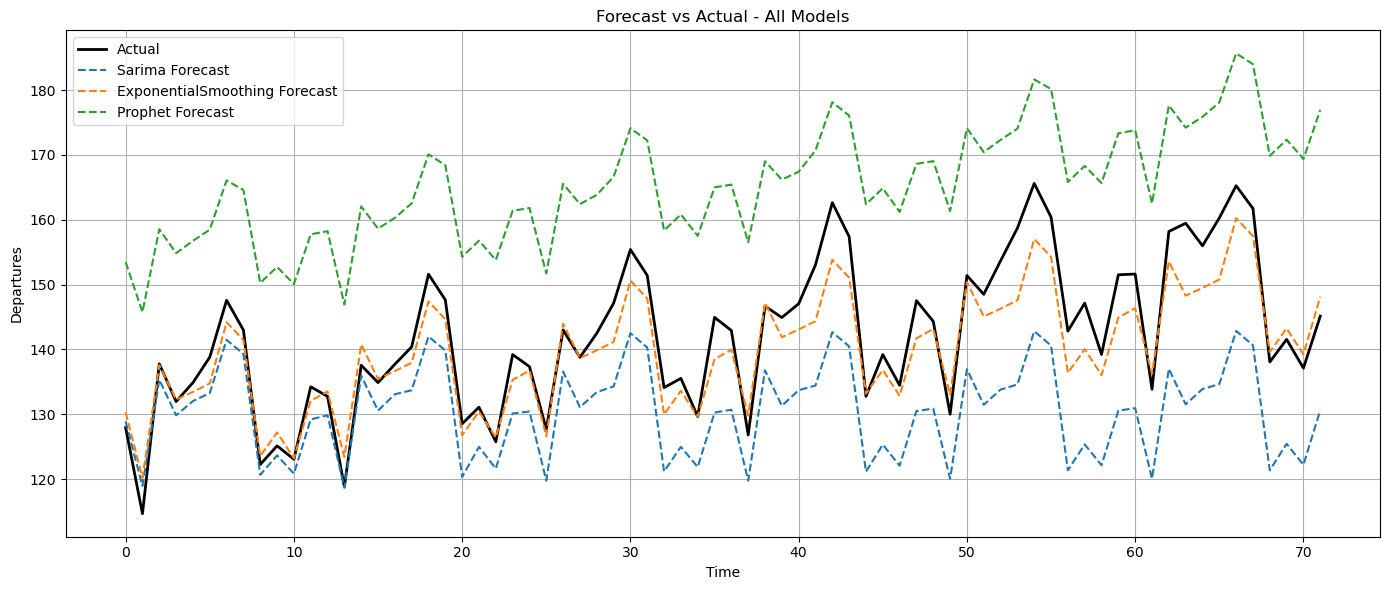

In [58]:
plot_forecasts(test_y, y_preds, models_names_list)

### Part 3 - exogenous data

We selected the CPI indicators for Energy, Transportation, and Gasoline because they are directly related to factors that influence flight activity. Energy and gasoline costs affect airline operational expenses, fuel prices, and ticket pricing. Transportation CPI reflects broader travel costs, including public and private transport demand. By combining these variables, we aim to capture both the cost-side and demand-side drivers that can help explain changes in the volume of flight departures.

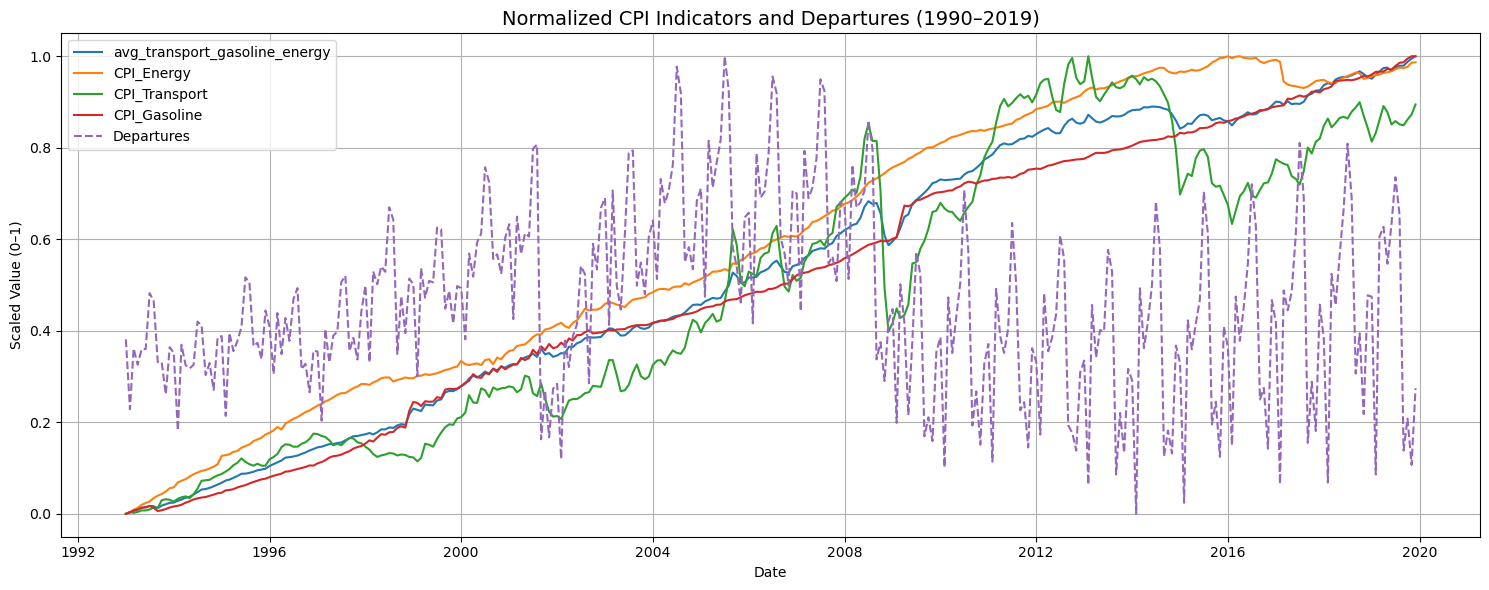

In [61]:
# --- 1. קריאה ועיבוד נתוני CPI ---
df = pd.read_csv("cpi.csv")
df = df[df['period'].str.startswith('M')]
df['month'] = df['period'].str.extract(r'M(\d{2})').astype(int)
df = df[(df['month'] >= 1) & (df['month'] <= 12)]
df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'].astype(str).str.zfill(2) + '-01')

# סינון טווח תאריכים
start_date = pd.Timestamp("1990-01-01")
end_date = pd.Timestamp("2019-12-01")
df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

# חלוקה לסדרות
energy_df = df[df['series_id'] == 'CUSR0000SAE']
transportation_df = df[df['series_id'] == 'CUSR0000SAT']
gasoline_df = df[df['series_id'] == 'CUSR0000SAG']

# --- 2. מיזוג סדרות ויצירת ממוצע חדש כולל אנרגיה ---
merged_all = pd.merge(
    transportation_df[['date', 'value']],
    gasoline_df[['date', 'value']],
    on='date',
    suffixes=('_transport', '_gasoline')
)

merged_all = pd.merge(
    merged_all,
    energy_df[['date', 'value']],
    on='date'
)
merged_all = merged_all.rename(columns={'value': 'value_energy'})

merged_all['avg_transport_gasoline_energy'] = merged_all[
    ['value_transport', 'value_gasoline', 'value_energy']
].mean(axis=1)

# --- 3. עיבוד נתוני הטיסות שלך ---
monthly_departures.index = pd.to_datetime(monthly_departures.index)
departures_df = monthly_departures.reset_index().rename(columns={'index': 'date'})

# --- 4. בניית DataFrame משולב ---
combined_df = merged_all[['date', 'avg_transport_gasoline_energy']].copy()

# הוספת שאר הסדרות
combined_df = combined_df.merge(energy_df[['date', 'value']], on='date', how='left')
combined_df = combined_df.rename(columns={'value': 'CPI_Energy'})

combined_df = combined_df.merge(transportation_df[['date', 'value']], on='date', how='left')
combined_df = combined_df.rename(columns={'value': 'CPI_Transport'})

combined_df = combined_df.merge(gasoline_df[['date', 'value']], on='date', how='left')
combined_df = combined_df.rename(columns={'value': 'CPI_Gasoline'})

combined_df = combined_df.merge(departures_df[['date', 'value']], on='date', how='left')
combined_df = combined_df.rename(columns={'value': 'Departures'})

# --- 5. נרמול ---
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(combined_df.drop(columns='date'))
scaled_df = pd.DataFrame(scaled_values, columns=combined_df.columns[1:], index=combined_df['date'])

# --- 6. ציור ---
plt.figure(figsize=(15, 6))

for col in scaled_df.columns:
    linestyle = '--' if col == 'Departures' else '-'
    plt.plot(scaled_df.index, scaled_df[col], label=col, linestyle=linestyle)


plt.title("Normalized CPI Indicators and Departures (1990–2019)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Scaled Value (0–1)")
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [62]:
required_cols = ['Departures', 'CPI_Energy', 'CPI_Transport', 'CPI_Gasoline']

combined_df['avg_transport_gasoline_energy'] = combined_df[
    ['CPI_Energy', 'CPI_Transport', 'CPI_Gasoline']
].mean(axis=1)

exog_variables = ['CPI_Energy', 'CPI_Transport', 'CPI_Gasoline', 'avg_transport_gasoline_energy']

results = []

for exog_var in exog_variables:
    print(f"Running SARIMA with exogenous variable: {exog_var}")

    # הסר ערכים חסרים
    df = combined_df[['Departures', exog_var]].dropna()

    # # נרמול (לא חובה אבל לפעמים עוזר)
    # scaler = MinMaxScaler()
    # df[exog_var] = scaler.fit_transform(df[[exog_var]])

    # חלוקה ל-train/test
    split_index = int(len(df) * 0.8)
    train_y = df['Departures'].iloc[:split_index]
    test_y = df['Departures'].iloc[split_index:]
    train_exog = df[[exog_var]].iloc[:split_index]
    test_exog = df[[exog_var]].iloc[split_index:]

    # SARIMA עם exog
    model = SARIMAX(train_y, exog=train_exog, order=(2, 0, 0), seasonal_order=(1, 1, 0, 12))
    fitted_model = model.fit(disp=False)

    # תחזית ובדיקת MSE
    forecast = fitted_model.forecast(steps=len(test_y), exog=test_exog)
    mse = mean_squared_error(test_y, forecast)

    results.append((exog_var, mse))

results_df = pd.DataFrame(results, columns=['Exogenous Variable', 'MSE']).sort_values(by='MSE')
print("\n MSE by Exogenous Variable:")
print(results_df)


Running SARIMA with exogenous variable: CPI_Energy
Running SARIMA with exogenous variable: CPI_Transport
Running SARIMA with exogenous variable: CPI_Gasoline
Running SARIMA with exogenous variable: avg_transport_gasoline_energy

 MSE by Exogenous Variable:
              Exogenous Variable        MSE
0                     CPI_Energy  10.432408
3  avg_transport_gasoline_energy  11.652834
1                  CPI_Transport  14.688570
2                   CPI_Gasoline  21.708036


In [63]:
print("\n🔄 Training SARIMA without exogenous variables...")

df_no_exog = combined_df[['Departures']].dropna()
split_index = int(len(df_no_exog) * 0.8)

train_y = df_no_exog['Departures'].iloc[:split_index]
test_y = df_no_exog['Departures'].iloc[split_index:]

model = SARIMAX(train_y, order=(2, 0, 0), seasonal_order=(1, 1, 0, 12))
fitted_model = model.fit(disp=False)
forecast = fitted_model.forecast(steps=len(test_y))

mse = mean_squared_error(test_y, forecast)
print(f"✅ SARIMA without exog done. MSE = {mse:.2f}")

# הוספה לתוצאות
results_df = pd.concat([
    results_df,
    pd.DataFrame([['SARIMA (no exog)', mse]], columns=['Exogenous Variable', 'MSE'])
])

# מיון מחדש
results_df = results_df.sort_values(by='MSE')
print("\n Final comparison including SARIMA without exog:")
print(results_df)



🔄 Training SARIMA without exogenous variables...
✅ SARIMA without exog done. MSE = 12.03

 Final comparison including SARIMA without exog:
              Exogenous Variable        MSE
0                     CPI_Energy  10.432408
3  avg_transport_gasoline_energy  11.652834
0               SARIMA (no exog)  12.027609
1                  CPI_Transport  14.688570
2                   CPI_Gasoline  21.708036


In [64]:
def plot_exog_vs_base_sarima(test_y, y_preds_exog, base_sarima_forecast, title="SARIMA Forecasts Comparison"):
    """
    Plots actual vs forecasted values for SARIMA models with exogenous variables
    and a base SARIMA model without exogenous variables.

    Parameters:
    - test_y: Series of actual values (with datetime index)
    - y_preds_exog: dict of exog_name -> forecast array (from SARIMA + exog)
    - base_sarima_forecast: forecast array from SARIMA without exogenous variable
    - title: plot title
    """
    plt.figure(figsize=(15, 6))

    # ציר X לפי אינדקס של סדרת האמת
    x = test_y.index

    # ערכים אמיתיים
    plt.plot(x, test_y, label='Actual', color='black', linewidth=2)

    # SARIMA בלי exog
    plt.plot(x, base_sarima_forecast, label='SARIMA (No exog)', color='gray', linestyle='--')

    # SARIMA עם כל exog
    for exog_name, forecast in y_preds_exog.items():
        plt.plot(x, forecast, label=f"SARIMA + {exog_name}", linestyle='--')

    # עיצוב
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Departures")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


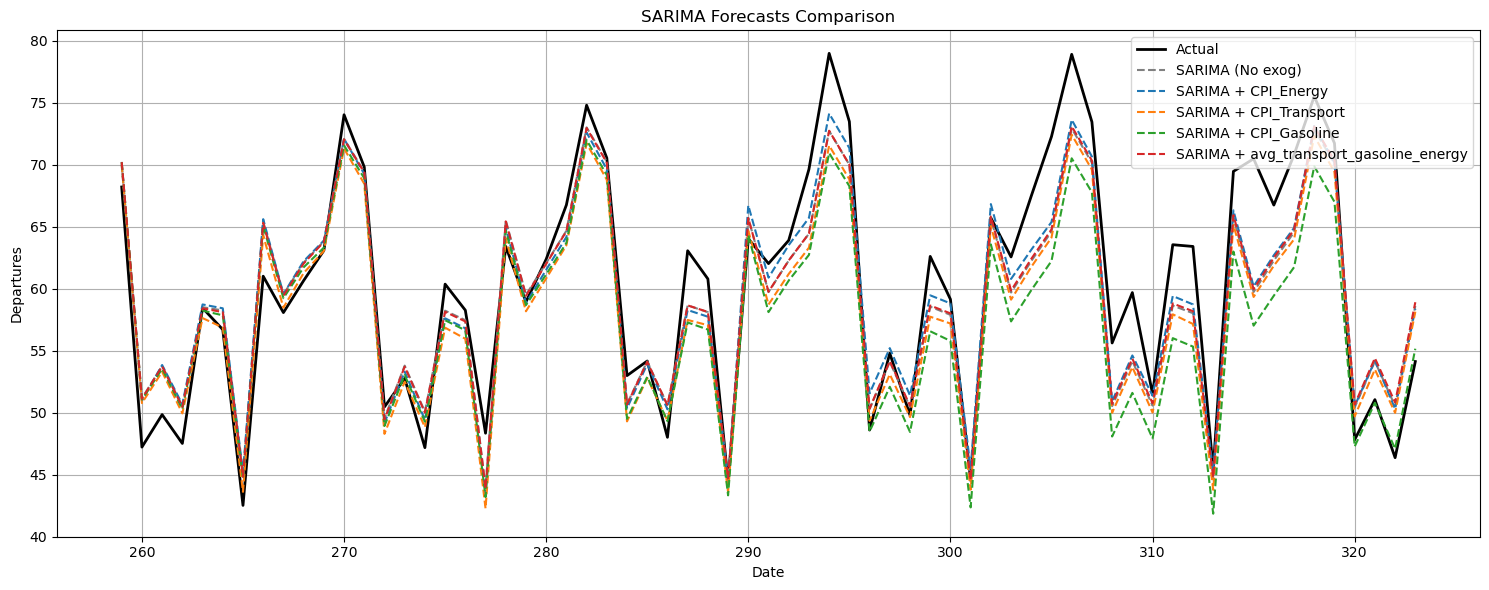

In [65]:
exog_variables = ['CPI_Energy', 'CPI_Transport', 'CPI_Gasoline', 'avg_transport_gasoline_energy']

# הכנה
y_preds_exog = {}
test_y = None
sarima_forecast = None

for exog_var in exog_variables:
    df = combined_df[['Departures', exog_var]].dropna()

    # יצירת train/test
    split_index = int(len(df) * 0.8)
    train_y = df['Departures'].iloc[:split_index]
    test_y = df['Departures'].iloc[split_index:]
    train_exog = df[[exog_var]].iloc[:split_index]
    test_exog = df[[exog_var]].iloc[split_index:]

    # אימון SARIMA עם exog
    model = SARIMAX(train_y, exog=train_exog, order=(2, 0, 0), seasonal_order=(1, 1, 0, 12))
    fitted = model.fit(disp=False)
    forecast = fitted.forecast(steps=len(test_y), exog=test_exog)

    # שמירת תחזית
    y_preds_exog[exog_var] = forecast

# SARIMA בלי exog
df_base = combined_df[['Departures']].dropna()
split_index = int(len(df_base) * 0.8)
train_y = df_base['Departures'].iloc[:split_index]
test_y = df_base['Departures'].iloc[split_index:]

model = SARIMAX(train_y, order=(2, 0, 0), seasonal_order=(1, 1, 0, 12))
fitted = model.fit(disp=False)
sarima_forecast = fitted.forecast(steps=len(test_y))

# ציור:
plot_exog_vs_base_sarima(test_y, y_preds_exog, sarima_forecast)
